### Case Study 2: Semantic Segmentation in Autonomous Driving
### Advanced Neural Networks Deep Learning Spatial Analysis
### Mohsin Mohammed

In [19]:
import os
import random
import shutil
import numpy as np
from PIL import Image
import torch
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


Setting up the Working files and Directories

In [8]:
# paths to original images and masks directories
train_images_dir = '/home/mohsin/School/Fall2024/Spatial_Analysis/Case_Study2/data/train'
train_masks_dir = '/home/mohsin/School/Fall2024/Spatial_Analysis/Case_Study2/labels/masks/train'

val_images_dir = '/home/mohsin/School/Fall2024/Spatial_Analysis/Case_Study2/data/val'
val_masks_dir = '/home/mohsin/School/Fall2024/Spatial_Analysis/Case_Study2/labels/masks/val'

# lists to hold image and mask paths
all_image_mask_pairs = []

# function to collect image-mask pairs
def collect_image_mask_pairs(images_dir, masks_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    pairs = []
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        base_name = os.path.splitext(img_file)[0]
        mask_filename = base_name + '.png'  # Adjust if your masks have a different naming convention
        mask_path = os.path.join(masks_dir, mask_filename)
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
        else:
            print(f"No mask found for image: {img_file}")
    return pairs

# Collect pairs from training and validation directories
train_pairs = collect_image_mask_pairs(train_images_dir, train_masks_dir)
val_pairs = collect_image_mask_pairs(val_images_dir, val_masks_dir)

# Combine the pairs
all_image_mask_pairs = train_pairs + val_pairs

print(f"Total images with masks after merging: {len(all_image_mask_pairs)}")

Total images with masks after merging: 80000


### Shuffle the Combined Dataset

In [9]:
# set the random seed for reproducibility
random.seed(42)

# shuffle the data
random.shuffle(all_image_mask_pairs)

### Split the Data into Training, Validation, and Test Sets


In [10]:
# subset sizes
train_size = 5000
val_size = 1000
test_size = 1000

# ensure there are enough images
total_available = len(all_image_mask_pairs)
required_total = train_size + val_size + test_size

if total_available < required_total:
    print(f"Not enough images. Available: {total_available}, Required: {required_total}")
    # adjust sizes proportionally
    scaling_factor = total_available / required_total
    train_size = int(train_size * scaling_factor)
    val_size = int(val_size * scaling_factor)
    test_size = int(test_size * scaling_factor)
    print(f"Adjusted sizes - Training: {train_size}, Validation: {val_size}, Test: {test_size}")

# split the data
train_pairs = all_image_mask_pairs[:train_size]
val_pairs = all_image_mask_pairs[train_size:train_size + val_size]
test_pairs = all_image_mask_pairs[train_size + val_size:train_size + val_size + test_size]

print(f"Training set size: {len(train_pairs)}")
print(f"Validation set size: {len(val_pairs)}")
print(f"Test set size: {len(test_pairs)}")


Training set size: 5000
Validation set size: 1000
Test set size: 1000


### Directories for the Subsets

In [11]:
# base directories for subsets
base_data_dir = '/home/mohsin/School/Fall2024/Spatial_Analysis/Case_Study2/data_subset'
base_masks_dir = '/home/mohsin/School/Fall2024/Spatial_Analysis/Case_Study2/labels_subset/masks'

# Paths for each subset
subset_train_images_dir = os.path.join(base_data_dir, 'train')
subset_train_masks_dir = os.path.join(base_masks_dir, 'train')

subset_val_images_dir = os.path.join(base_data_dir, 'val')
subset_val_masks_dir = os.path.join(base_masks_dir, 'val')

subset_test_images_dir = os.path.join(base_data_dir, 'test')
subset_test_masks_dir = os.path.join(base_masks_dir, 'test')

# create directories if they don't exist
os.makedirs(subset_train_images_dir, exist_ok=True)
os.makedirs(subset_train_masks_dir, exist_ok=True)
os.makedirs(subset_val_images_dir, exist_ok=True)
os.makedirs(subset_val_masks_dir, exist_ok=True)
os.makedirs(subset_test_images_dir, exist_ok=True)
os.makedirs(subset_test_masks_dir, exist_ok=True)


### Copy the Files to the Subset Directories

In [12]:
# function to copy files to a destination directory
def copy_files(pairs, images_dir, masks_dir):
    for img_path, mask_path in pairs:
        # Copy image
        dst_img_path = os.path.join(images_dir, os.path.basename(img_path))
        shutil.copy(img_path, dst_img_path)

        # Copy mask
        dst_mask_path = os.path.join(masks_dir, os.path.basename(mask_path))
        shutil.copy(mask_path, dst_mask_path)

# copy training files
copy_files(train_pairs, subset_train_images_dir, subset_train_masks_dir)

# copy validation files
copy_files(val_pairs, subset_val_images_dir, subset_val_masks_dir)

# copy test files
copy_files(test_pairs, subset_test_images_dir, subset_test_masks_dir)


### Checking Class Imbalance in our dataset

Based on the BDD100K Documentation, 

For the drivable area task, there are 3 classes in the segmentation task. They are:

0: direct
1: alternative
2: background

In [50]:
# load mask data for checking class imbalance
def load_masks(mask_folder):
    mask_files = [os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith('.png')]
    masks = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in mask_files]
    return masks

mask_folder = '/home/mohsin/School/Fall2024/Spatial_Analysis/Case_Study2/labels_subset/masks/train'
check_masks_class_imbalance = load_masks(mask_folder)


# function to calulate the class frequencies
def calculate_class_frequencies(masks):
    """ gives the normalized frequency of each class across all masks, showing how much each class contributes to the dataset"""
    unique, counts = np.unique(np.concatenate(masks, axis=None), return_counts=True)
    frequency_dict = dict(zip(unique, counts))
    total_pixels = sum(counts)
    class_frequencies = {k: v / total_pixels for k, v in frequency_dict.items()}
    return class_frequencies

class_frequencies = calculate_class_frequencies(check_masks_class_imbalance)
print("Class Frequencies:", class_frequencies)


Class Frequencies: {np.uint8(0): np.float64(0.12190603038194445), np.uint8(1): np.float64(0.049127533637152776), np.uint8(2): np.float64(0.8289664359809028)}


PLot the class frequencies

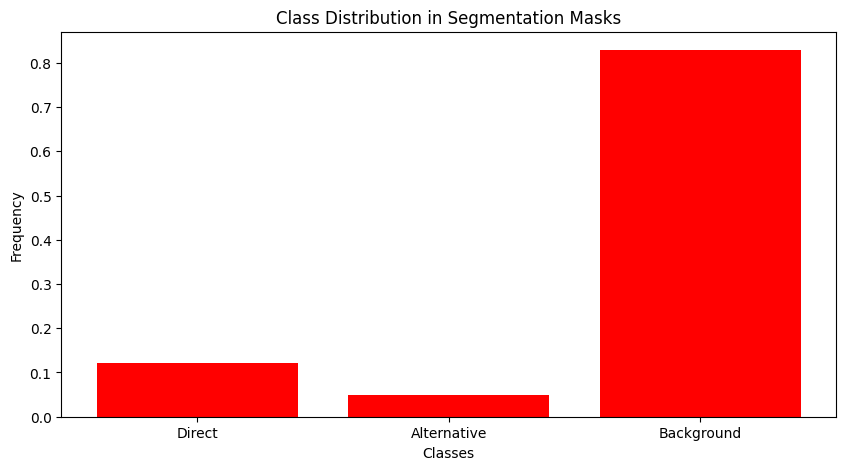

In [24]:
class_labels = {0: 'Direct', 1: 'Alternative', 2: 'Background'}


def plot_class_distribution(class_frequencies, class_labels):
    # extract classes and frequencies
    classes = list(class_frequencies.keys())
    frequencies = list(class_frequencies.values())
    
    # map numeric classes to string labels
    labels = [class_labels[cls] for cls in classes]

    # create the plot
    plt.figure(figsize=(10, 5))
    plt.bar(labels, frequencies, color='red')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Class Distribution in Segmentation Masks')
    plt.xticks(labels)
    plt.show()

plot_class_distribution(class_frequencies, class_labels)


These class frequencies from the segmentation masks highlight that the majority of the training data focuses on background areas, with a smaller representation of direct and even less of alternative drivable paths. 

To address this significant class imbalance, we can adjust the loss function to penalize misclassifications of the minority classes more than the majority class. This can help balance the influence each class has on the model training. 

We can do this by adjusting the weights inversely proportional to the class frequencies. 

### Calculate Inverse Weights to address class imbalance and for visualize the same

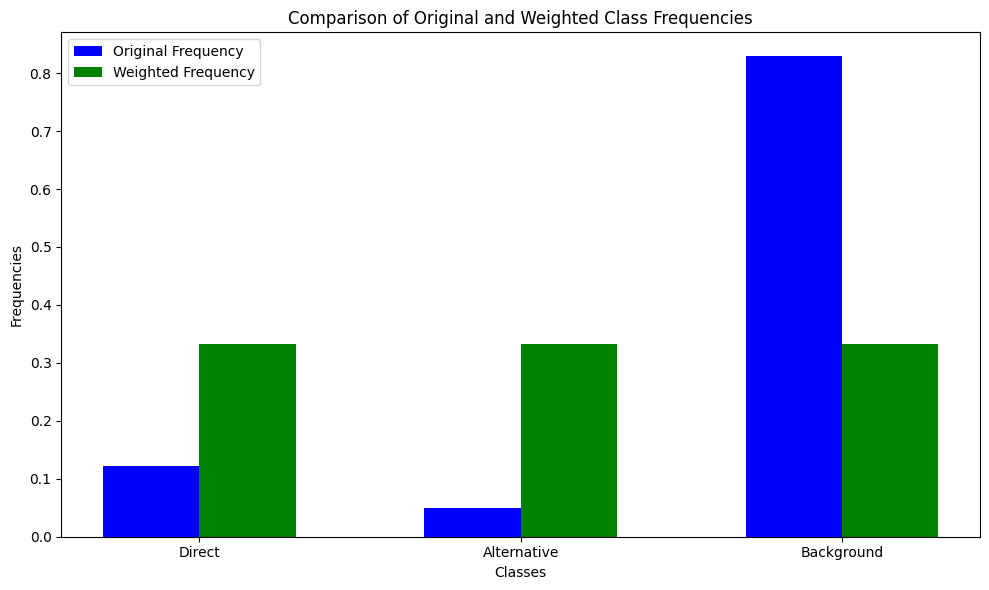

In [51]:
class_labels = ['Direct', 'Alternative', 'Background']
# manual conversion  but we will calculate these dynamically for passing to the loss function for weights
class_frequencies_visual = np.array([0.1219, 0.0491, 0.8289])
weights_visual = np.array([1/0.1219, 1/0.0491, 1/0.8289])

# calculate weighted frequencies
weighted_frequencies = class_frequencies_visual * weights_visual
weighted_frequencies /= weighted_frequencies.sum()  # Normalize

# normalize weights for comparison
normalized_weights = weights_visual / weights_visual.sum()

x = np.arange(len(class_labels))

# plot
plt.figure(figsize=(10, 6))
plt.bar(x - 0.15, class_frequencies_visual, width=0.3, label='Original Frequency', color='blue', align='center')
plt.bar(x + 0.15, weighted_frequencies, width=0.3, label='Weighted Frequency', color='green', align='center')

# adding labels and titles
plt.xlabel('Classes')
plt.ylabel('Frequencies')
plt.title('Comparison of Original and Weighted Class Frequencies')
plt.xticks(x, class_labels)  # Set class labels as x-axis labels
plt.legend()

# show plot
plt.tight_layout()
plt.show()

Now that our class imbalance is addressed, we are in a better position to train the model

### Calculating the weights dynamically and passing to the GPU device for passing the inverse weights to the loss function 

In [52]:
# using GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

weights = np.array([1/freq if freq > 0 else 0 for freq in class_frequencies.values()])

# normalize weights to make sure they sum to the number of classes
weights /= weights.sum()
weights *= len(class_frequencies)
weights = torch.tensor(weights, dtype=torch.float32)

# move the weights to the device
weights = weights.to(device)

### Custom Dataset Class

In [53]:
class DrivableAreaDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=(736, 1280)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_size = image_size
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # load image and mask
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # resize to consistent dimensions
        image = cv2.resize(image, self.image_size[::-1])  # reverse to (width, height)
        mask = cv2.resize(mask, self.image_size[::-1], interpolation=cv2.INTER_NEAREST)

        # normalize the image to [0, 1] and convert to tensor
        image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)  # shape: [C, H, W]
        mask = torch.tensor(mask, dtype=torch.long)  # shape: [H, W]

        return image, mask


### Dataloader

In [54]:
# directories
train_images_dir = subset_train_images_dir
train_masks_dir = subset_train_masks_dir
val_images_dir = subset_val_images_dir
val_masks_dir = subset_val_masks_dir
test_images_dir = subset_test_images_dir
test_masks_dir = subset_test_masks_dir

# datasets
train_dataset = DrivableAreaDataset(images_dir=train_images_dir, masks_dir=train_masks_dir)
val_dataset = DrivableAreaDataset(images_dir=val_images_dir, masks_dir=val_masks_dir)
test_dataset = DrivableAreaDataset(images_dir=test_images_dir, masks_dir=test_masks_dir)

# dataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

### Early Stopping Class

In [56]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, val_loss):
        if val_loss < self.min_validation_loss:
            self.min_validation_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


### Model Buiilding, Training, Validation, & Plotting Losses

Using device: cuda
Epoch [1/50], Param group 0 LR: 0.0010000
Saved new best model at epoch 1 with validation loss: 0.5051
Epoch [1/50], Training Loss: 0.6299, Validation Loss: 0.5051
Epoch [2/50], Param group 0 LR: 0.0010000
Saved new best model at epoch 2 with validation loss: 0.4030
Epoch [2/50], Training Loss: 0.4520, Validation Loss: 0.4030
Epoch [3/50], Param group 0 LR: 0.0010000
Saved new best model at epoch 3 with validation loss: 0.3385
Epoch [3/50], Training Loss: 0.3977, Validation Loss: 0.3385
Epoch [4/50], Param group 0 LR: 0.0010000
Epoch [4/50], Training Loss: 0.3727, Validation Loss: 0.3508
Epoch [5/50], Param group 0 LR: 0.0010000
Saved new best model at epoch 5 with validation loss: 0.3314
Epoch [5/50], Training Loss: 0.3424, Validation Loss: 0.3314
Epoch [6/50], Param group 0 LR: 0.0010000
Saved new best model at epoch 6 with validation loss: 0.3257
Epoch [6/50], Training Loss: 0.3280, Validation Loss: 0.3257
Epoch [7/50], Param group 0 LR: 0.0010000
Saved new best m

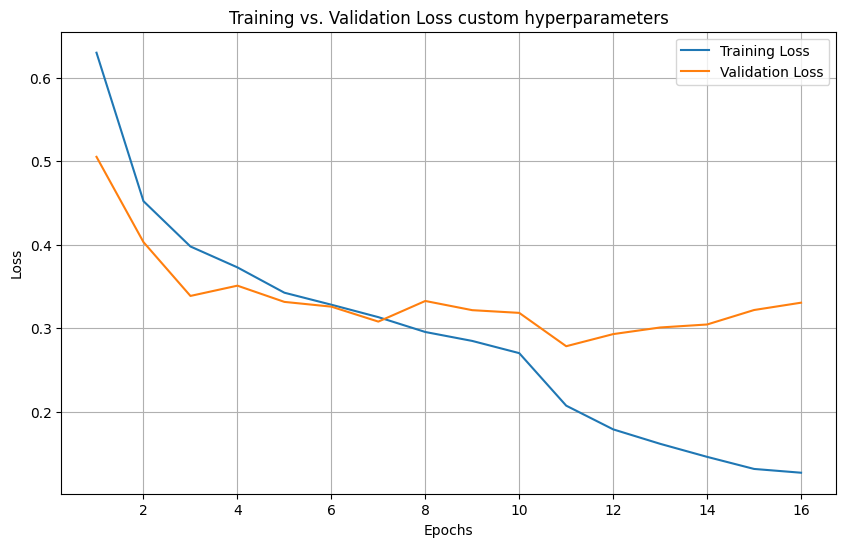

<Figure size 640x480 with 0 Axes>

Plot saved as training_vs_validation_loss_after_addressing_class_imbalance_and_LR.png


In [60]:
print(f"Using device: {device}")

# define the model
model = smp.Unet(
    encoder_name='resnet34',       # encoder: ResNet34
    encoder_weights='imagenet',   # ImageNet pre-trained weights
    in_channels=3,                # RGB input
    classes=3                 
).to(device)


# define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)   # the weights here correspond to the inverse weights calculated earlier to address class imbalance
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

min_lr = 1e-7  # Define the minimum learning rate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True, min_lr=min_lr)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)


# initialize lists to store loss values and learning rates
train_losses = []
val_losses = []
lr_rates = []
best_val_loss = float('inf')

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # training phase
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # Move to GPU/CPU

        # forward pass
        outputs = model(images)  # Predicted outputs
        loss = criterion(outputs, masks)  # Add channel dimension to masks

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  # Accumulate loss

    # calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Store training loss
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)  # Accumulate validation loss

    # calculate average validation loss for the epoch
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    # step the scheduler with the current epoch's validation loss
    scheduler.step(val_loss)

    # print the learning rates for each parameter group
    for i, param_group in enumerate(optimizer.param_groups):
        print(f"Epoch [{epoch + 1}/{num_epochs}], Param group {i} LR: {param_group['lr']:.7f}")

    if early_stopper.early_stop(val_loss):
        print(f"Stopping early at epoch {epoch + 1}")
        break

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_drivable_segmentation_model.pth")  # Save the best model
        print(f"Saved new best model at epoch {epoch+1} with validation loss: {val_loss:.4f}")

    # Print epoch summary
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")


# plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss custom hyperparameters')
plt.legend()
plt.grid()
plt.show()


# save the plot as an image
plot_path = "training_vs_validation_loss_after_addressing_class_imbalance_and_LR.png"
plt.savefig(plot_path)  # save the plot
plt.show()

print(f"Plot saved as {plot_path}")



### Helper functions to help preprocess the images for predictions and plotting

In [61]:
def preprocess_image(image_path, image_size=(736, 1280)):
    """
    Preprocess the input image: resize, normalize, and convert to tensor.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size[::-1])  # Resize to (width, height)
    image = image / 255.0  # Normalize to [0, 1]
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to tensor [C, H, W]
    return image.unsqueeze(0)  # Add batch dimension


def preprocess_mask(mask_path, image_size=(736, 1280)):
    """
    Preprocess the ground truth mask: resize and convert to tensor.
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, image_size[::-1], interpolation=cv2.INTER_NEAREST)  # Resize to (width, height)
    mask = torch.tensor(mask, dtype=torch.long)  # Convert to tensor [H, W]
    return mask


def display_results(image, ground_truth, predicted, idx):
    """
    Display the input image, ground truth mask, and predicted segmentation.
    """
    # convert tensors to numpy arrays for visualization
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # [H, W, C]
    ground_truth = ground_truth.cpu().numpy()  # [H, W]
    predicted = predicted.cpu().numpy()  # [H, W]

    # plot the results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title(f"Input Image {idx + 1}")
    axs[0].axis("off")

    axs[1].imshow(ground_truth, cmap='viridis')
    axs[1].set_title(f"Ground Truth {idx + 1}")
    axs[1].axis("off")

    axs[2].imshow(predicted, cmap='viridis')
    axs[2].set_title(f"Predicted Mask {idx + 1}")
    axs[2].axis("off")

    plt.show()

### Prepare directories and images

In [62]:
# paths to test images and masks
test_images_dir = "/home/mohsin/School/Fall2024/Spatial_Analysis/Case_Study2/data_subset/test"
test_masks_dir = "/home/mohsin/School/Fall2024/Spatial_Analysis/Case_Study2/labels_subset/masks/test"


# randomly pick 3 images
image_files = sorted(os.listdir(test_images_dir))
mask_files = sorted(os.listdir(test_masks_dir))


# ensure image and mask file correspondence
assert len(image_files) == len(mask_files), "Mismatch in number of images and masks."
for img, mask in zip(image_files, mask_files):
    assert os.path.splitext(img)[0] == os.path.splitext(mask)[0], "Image and mask filenames do not match."

# randomly pick 3 indices
random_indices = random.sample(range(len(image_files)), 3)


### Make Predictions using the best saved model

/tmp/ipykernel_7894/32479206.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_drivable_segmentation_model.pth"))


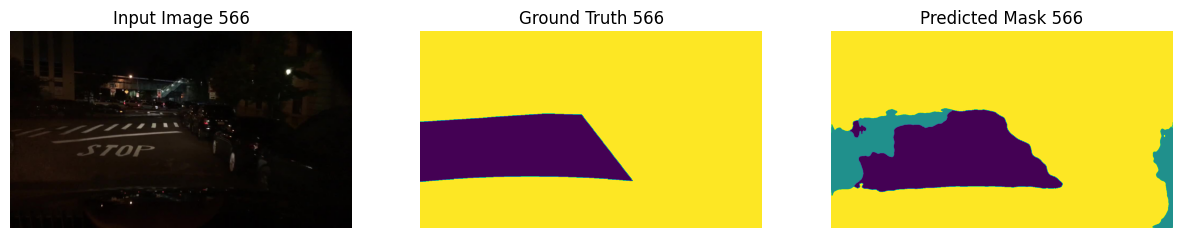

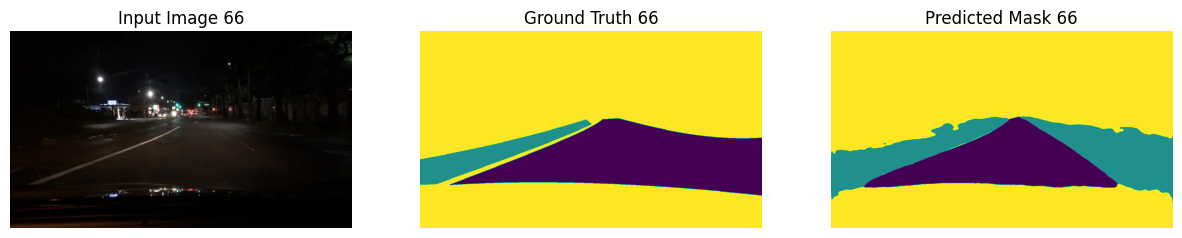

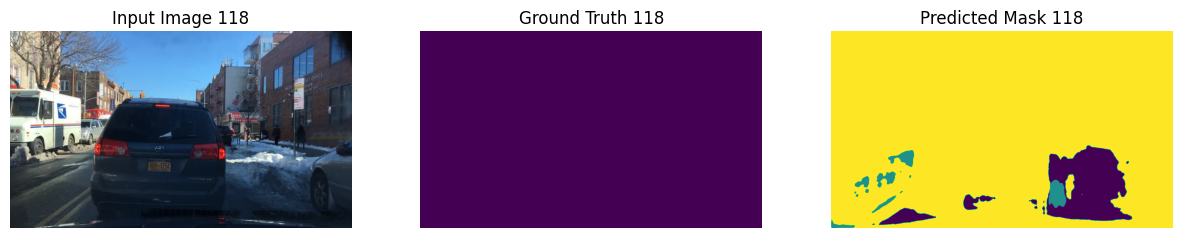

In [66]:
# load the best saved model to make predictions
model.load_state_dict(torch.load("best_drivable_segmentation_model.pth"))
# load and predict for 3 random images with their corresponding masks
model.eval()  # Set model to evaluation mode
for idx in random_indices:
    image_path = os.path.join(test_images_dir, image_files[idx])
    mask_path = os.path.join(test_masks_dir, mask_files[idx])

    # preprocess image and mask
    image = preprocess_image(image_path).to(device)
    ground_truth = preprocess_mask(mask_path).to(device)

    # predict segmentation
    with torch.no_grad():
        output = model(image)  # Model output: [1, num_classes, H, W]
        predicted = torch.argmax(output, dim=1).squeeze(0)  # Predicted mask: [H, W]

    # display the results
    display_results(image, ground_truth, predicted, idx)

### Compute Metrics (Intersection over Union)

In [67]:
def compute_iou(pred_mask, true_mask, num_classes):
    """
    Compute IoU for each class and the mean IoU.
    Args:
        pred_mask (torch.Tensor): Predicted mask of shape [H, W].
        true_mask (torch.Tensor): Ground truth mask of shape [H, W].
        num_classes (int): Number of classes.
    Returns:
        per_class_iou (list): IoU for each class.
        mean_iou (float): Mean IoU across all classes.
    """
    pred_mask = pred_mask.cpu().numpy()
    true_mask = true_mask.cpu().numpy()

    iou_per_class = []
    for cls in range(num_classes):
        intersection = np.logical_and(pred_mask == cls, true_mask == cls).sum()
        union = np.logical_or(pred_mask == cls, true_mask == cls).sum()
        if union == 0:
            iou = float('nan')  # If no pixels belong to this class in both masks
        else:
            iou = intersection / union
        iou_per_class.append(iou)

    # compute mean IoU ignoring NaN values
    mean_iou = np.nanmean(iou_per_class)
    return iou_per_class, mean_iou

In [68]:
num_classes = 3  # based on the three segmentation classes in the esegmentation masks

# accumulate IoU for all images
iou_scores = []
model.eval()
with torch.no_grad():
    for image_path, mask_path in zip(image_files, mask_files):
        # load and preprocess image and mask
        image = preprocess_image(os.path.join(test_images_dir, image_path)).to(device)
        ground_truth = preprocess_mask(os.path.join(test_masks_dir, mask_path)).to(device)

        # predict segmentation
        output = model(image)
        predicted = torch.argmax(output, dim=1).squeeze(0)  # Predicted mask: [H, W]

        # compute IoU
        _, mean_iou = compute_iou(predicted, ground_truth, num_classes=num_classes)
        iou_scores.append(mean_iou)

# Calculate average IoU over the dataset
dataset_mean_iou = np.nanmean(iou_scores)
print(f"Test Mean IoU: {dataset_mean_iou:.4f}")


Test Mean IoU: 0.6385


### Augmenting the training data using albumentations library and measuring model performance

In [69]:
def get_train_augmentation():
    """
    Augmentation pipeline for training images and masks.
    """
    return A.Compose([
        # Spatial Transformations
        A.HorizontalFlip(p=0.5),  # Flip image and mask horizontally
        A.RandomRotate90(p=0.5),  # Rotate 90 degrees randomly

        # Geometric Transformations
        A.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5, border_mode=0
        ),

        # Crop and Resize
        A.RandomCrop(height=512, width=512, p=1.0),  # Crop to a fixed size
        A.Resize(height=736, width=1280),  # Resize to fixed size (ensure divisible by 32)

        # Photometric Transformations (applied to images only)
        A.RandomBrightnessContrast(p=0.2),
        A.ColorJitter(p=0.2),

        # Normalize and Convert to Tensors
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_validation_augmentation():
    """
    Minimal preprocessing for validation images and masks.
    """
    return A.Compose([
        A.Resize(height=736, width=1280),  # Resize to fixed size
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


### Augmented dataset class

In [70]:
class DrivableAreaDatasetAugmented(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # Transformed image tensor
            mask = augmented['mask']    # Transformed mask tensor

        # Convert mask to tensor
        # mask = torch.tensor(mask, dtype=torch.long)  # Shape: [H, W]
        mask = mask.clone().detach().to(torch.long)

        return image, mask


### Augmented Datasets

In [71]:
# Create augmented datasets
train_dataset_aug = DrivableAreaDatasetAugmented(
    images_dir=train_images_dir,
    masks_dir=train_masks_dir,
    transform=get_train_augmentation(),
)

val_dataset_aug = DrivableAreaDatasetAugmented(
    images_dir=val_images_dir,
    masks_dir=val_masks_dir,
    transform=get_validation_augmentation(),
)

# Create DataLoaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=8, shuffle=True, num_workers=4)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=8, shuffle=False, num_workers=4)
test_loader_aug = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

### Augmented Model

Using device: cuda
Epoch [1/50], Param group 0 LR: 0.0010000
Saved new best model at epoch 1 with validation loss: 1.0020
Epoch [1/50], Training Loss: 0.9101, Validation Loss: 1.0020
Epoch [2/50], Param group 0 LR: 0.0010000
Saved new best model at epoch 2 with validation loss: 0.8123
Epoch [2/50], Training Loss: 0.8390, Validation Loss: 0.8123
Epoch [3/50], Param group 0 LR: 0.0010000
Epoch [3/50], Training Loss: 0.8081, Validation Loss: 0.8399
Epoch [4/50], Param group 0 LR: 0.0010000
Saved new best model at epoch 4 with validation loss: 0.7702
Epoch [4/50], Training Loss: 0.7817, Validation Loss: 0.7702
Epoch [5/50], Param group 0 LR: 0.0010000
Epoch [5/50], Training Loss: 0.7629, Validation Loss: 0.7808
Epoch [6/50], Param group 0 LR: 0.0010000
Epoch [6/50], Training Loss: 0.7456, Validation Loss: 0.8194
Epoch [7/50], Param group 0 LR: 0.0010000
Saved new best model at epoch 7 with validation loss: 0.7444
Epoch [7/50], Training Loss: 0.7398, Validation Loss: 0.7444
Epoch [8/50], Pa

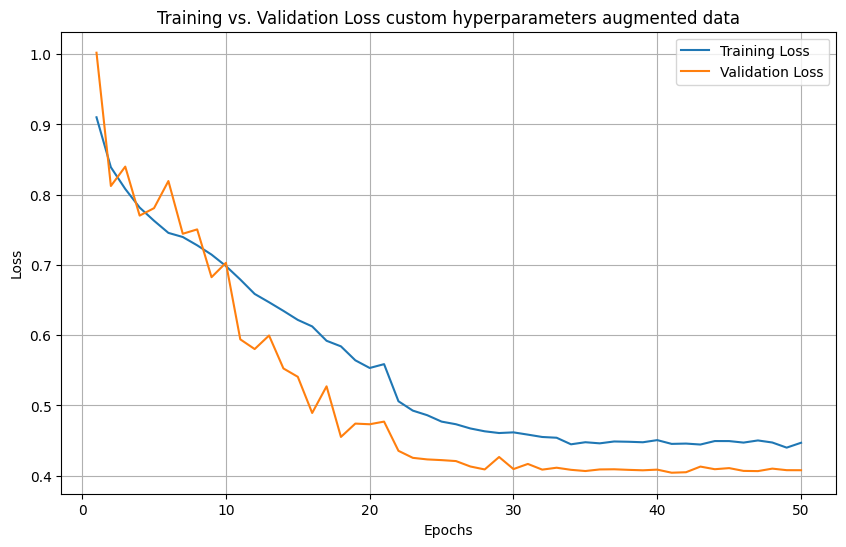

<Figure size 640x480 with 0 Axes>

Plot saved as training_vs_validation_loss_after_addressing_class_imbalance_and_LR_aug.png


In [75]:
model = smp.Unet(
    encoder_name='resnet34',       # Encoder: ResNet34
    encoder_weights='imagenet',   # Use ImageNet pre-trained weights
    in_channels=3,                # RGB input
    classes=3                 
).to(device)


# define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

min_lr = 1e-7  # Define the minimum learning rate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True, min_lr=min_lr)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

print(f"Using device: {device}")

# Initialize lists to store loss values and learning rates
train_losses_aug = []
val_losses_aug = []
best_val_loss = float('inf')

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training phase
    for images, masks in train_loader_aug:
        images, masks = images.to(device), masks.to(device)  # Move to GPU/CPU

        # Forward pass
        outputs = model(images)  # Predicted outputs
        loss = criterion(outputs, masks)  # Add channel dimension to masks

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  # Accumulate loss

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader_aug.dataset)
    train_losses_aug.append(epoch_loss)  # Store training loss
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, masks in val_loader_aug:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)  # Accumulate validation loss

    # Calculate average validation loss for the epoch
    val_loss /= len(val_loader_aug.dataset)
    val_losses_aug.append(val_loss)  # Store validation loss
    # step the scheduler with the current epoch's validation loss
    scheduler.step(val_loss)

    # Print the learning rates for each parameter group
    for i, param_group in enumerate(optimizer.param_groups):
        print(f"Epoch [{epoch + 1}/{num_epochs}], Param group {i} LR: {param_group['lr']:.7f}")

    if early_stopper.early_stop(val_loss):
        print(f"Stopping early at epoch {epoch + 1}")
        break

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_drivable_segmentation_model_aug.pth")  # Save the best model
        print(f"Saved new best model at epoch {epoch+1} with validation loss: {val_loss:.4f}")

    # Print epoch summary
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")


# plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_aug) + 1), train_losses_aug, label='Training Loss')
plt.plot(range(1, len(val_losses_aug) + 1), val_losses_aug, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss custom hyperparameters augmented data')
plt.legend()
plt.grid()
plt.show()


# save the plot as an image
plot_path = "training_vs_validation_loss_after_addressing_class_imbalance_and_LR_aug.png"
plt.savefig(plot_path)  # save the plot
plt.show()

print(f"Plot saved as {plot_path}")


In [76]:
num_classes = 3  # based on the classes in the segmentation masks 

# load saved weights
model.load_state_dict(torch.load("best_drivable_segmentation_model_aug.pth"))

# accumulate IoU for all images
iou_scores = []
model.eval()
with torch.no_grad():
    for image_path, mask_path in zip(image_files, mask_files):
        # Load and preprocess image and mask
        image = preprocess_image(os.path.join(test_images_dir, image_path)).to(device)
        ground_truth = preprocess_mask(os.path.join(test_masks_dir, mask_path)).to(device)

        # predict segmentation
        output = model(image)
        predicted = torch.argmax(output, dim=1).squeeze(0)  # Predicted mask: [H, W]

        # compute IoU
        _, mean_iou = compute_iou(predicted, ground_truth, num_classes=num_classes)
        iou_scores.append(mean_iou)

# calculate average IoU over the dataset
dataset_mean_iou = np.nanmean(iou_scores)
print(f"Test Mean IoU: {dataset_mean_iou:.4f}")


/tmp/ipykernel_7894/3432126540.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_drivable_segmentation_model_aug.pth"))


Test Mean IoU: 0.3588


Despite implementing a diverse augmentation pipeline aimed at increasing data variability and improving the model's generalization ability, the final IoU score after 50 epochs fell to 0.3588, indicating that the chosen augmentation strategy did not facilitate better learning or convergence. Several factors may contribute to this outcome. For instance, overly aggressive augmentations could introduce unrealistic conditions, making the training data distribution drift too far from real-world scenarios

However one thing to note was this behaviour was expected, since the issue here not availability of data, infact there is way more data available than the current GPU can process. Data augmentation was used to see if variability in the current training data could help the model generalize the data better, however, it did not help in this case.

The alternative would be to increase computational power and increase training to cover more images.